# "A data-driven biology-based network model reproduces C. elegans premotor neural dynamics" figure bookmarks


### [Results -> Analysis -> Promoter and suppressor signal neurons -> Figure 5](#Figure-5)

Go to [load processed White graph data](#White_graph_data)

Go to [Find highly correlated neurons](#Find_highly_correlated_neurons)

Go to [Simulation setup data](#simulation_setup_data)

Go to [ODE simulation](#ODE_simulation)

Go to [Behavioral timeseries](#Behavioral_timeseries)

### Run many simulations and compute higher order stats, test with and without EJ and Syn

In [1]:

curdir = pwd()
dir_one_up = abspath(joinpath(curdir, ".."))

"/Users/mmtre/Library/CloudStorage/OneDrive-IllinoisInstituteofTechnology/Github repos/Celegans_premotor/"

In [2]:
# using Pkg
# Pkg.update()

In [3]:
using LinearAlgebra
using DifferentialEquations
using Statistics
using SparseArrays

using JSON
using SavitzkyGolay
using Plots
using Measures  # <- needed to use mm, cm, px, etc.
using LaTeXStrings

using StatsPlots
using DataInterpolations

using SciMLBase
using OrdinaryDiffEq

using Plots, ImplicitEquations
using ImplicitPlots
using Roots

using NonlinearSolve, SteadyStateDiffEq
using NLsolve

using Random

##########################
### set font defaults ####
##########################
plot_font = "Computer Modern"

default(
    fontfamily=plot_font,
    titlefontsize = 11,
    labelfontsize = 9,
    linewidth=2, 
    framestyle=:nothing, 
    label=nothing, 
    grid=true
)


#####################################
######     Make colors   ############
#####################################
color_array = ["43c7c0","6ed0ca","99d8d4","c4e0de","efe8e7","f3b8b6","f68785","f95754","fc2622"]
# Convert hexadecimal colors to RGB colors
rgb_colors = [parse(RGB, "#" * color) for color in color_array]



clrsp = palette(:batlow10)
clrs = [clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[2], clrsp[5], clrsp[5],
    clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8], clrsp[8]]

clrs_short = [clrsp[2], clrsp[8]]


display(clrsp)
display(rgb_colors)
display(clrs)

grey_colors = ["e5e6e4","e5e5e5", "b1a7a6", "adb5bd", "6c757d"]
rgb_greys = [parse(RGB, "#" * color) for color in grey_colors]

display(rgb_greys)

In [4]:
#################################
#### load saved functions  ######
#################################

filename = "functions_regression.jl"
data_folder = "functions"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
include(filepath)

#include("functions/functions_regression.jl")
######### contains functions .. #########
## RELU
## Data_Replacement

filename = "functions_simulation.jl"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
include(filepath)

#include("functions/functions_simulation.jl")
######### contains functions .. #########
## lorenz!
## moving_average
## heaviside_pulse


heaviside_pulse (generic function with 1 method)

## White_graph_data



In [5]:
using DataFrames
using CSV

data_folder = "data/White_data_processed"
filename = "df5.csv"
#filepath = joinpath(joinpath(full_pth, data_folder), filename);
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);
df5 = DataFrame(CSV.File(filepath));

############################################
### take processed data from White #########
############################################

out_set = collect(Set(df5[!, :"Neuron2"]))
in_set = collect(Set(df5[!, :"Neuron1"]))
final_neurons = union(out_set, in_set)
N = size(final_neurons)[1]  ## number of neurons in my model
final_neuron_dict = Dict(zip(final_neurons, collect(1:N)))

#############################
### make EJ matrix ##########
#############################
df_EJ = filter(row -> row."Type" == "EJ",df5) # df_subset
EJ_mat = zeros(N,N)
for i in collect(1:size(df_EJ,1))
    w_tmp = df_EJ[i,:]["Nbr"]
    neuro1 = df_EJ[i,:]["Neuron1"]
    neuro2 = df_EJ[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    EJ_mat[id1, id2] = w_tmp
end

#############################
### make Syn matrix #########
#############################
df_S = filter(row -> row."Type" == "S",df5) # df_subset
S_mat = zeros(N,N)

for i in collect(1:size(df_S,1))
    w_tmp = df_S[i,:]["Nbr"]
    neuro1 = df_S[i,:]["Neuron1"]
    neuro2 = df_S[i,:]["Neuron2"]
    id1 = final_neuron_dict[neuro1]
    id2 = final_neuron_dict[neuro2]
    S_mat[id1, id2] = w_tmp
end

S_mat = S_mat'; # transpose for matrix multiplication
S_mat_bool = S_mat .!=0;

## Simulate core neurons using avg regression weights
### (avg weights computed from compute_avg_weights.ipynb)

In [6]:
using JLD2

data_folder = "data/model_weights"
filename = "avg_model_weights.jld2"
filepath = joinpath(joinpath(dir_one_up, data_folder), filename);


#@save filepath A_10takes_avg d_10takes_avg
@load filepath A_10takes_avg d_10takes_avg


2-element Vector{Symbol}:
 :A_10takes_avg
 :d_10takes_avg

## Find_highly_correlated_neurons

In [7]:
#include("make_switchout_list.jl")
######### contains .. #########
## computes list of "highly_correlated_neurons"
## makes "switchout_list"


##########################################
### find higherly correlated neurons,  ###
### use these neurons as candidate     ###
### replacements when neuron is missing ##
##########################################

data_folder = "data/Atanas_data"

fn1 = "2023-03-07-01.json"
fn2 = "2023-01-23-21.json"
fn3 = "2023-01-23-15.json"  # avb (use for test?)
fn4 = "2023-01-19-22.json"
fn5 = "2023-01-19-15.json" # avb
fn6 = "2023-01-19-08.json" # avb
fn7 = "2023-01-19-01.json" # avb
fn8 = "2023-01-17-14.json"
fn9 = "2023-01-17-07.json"
fn10 = "2023-01-16-22.json" #avb, heat
fn11 = "2023-01-16-15.json"
fn12 = "2023-01-16-08.json" #avb, heat
fn13 = "2023-01-10-14.json" #avb, heat  (use this for plot example!)
fn14= "2023-01-10-07.json"  #avb, heat
fn15 = "2023-01-09-28.json"
fn16 = "2023-01-09-22.json"
fn17 = "2023-01-09-15.json"
fn18 = "2023-01-09-08.json" #avb, heat
fn19 = "2023-01-06-15.json"
fn20 = "2023-01-06-08.json"
fn21 = "2023-01-06-01.json"
fn22 = "2023-01-05-18.json" #avb, heat
fn23 = "2023-01-05-01.json"
fn24 = "2022-12-21-06.json"
fn25 = "2022-08-02-01.json"
fn26 = "2022-07-20-01.json"
fn27 = "2022-06-28-07.json"
fn28= "2022-06-28-01.json"
fn29 = "2022-06-14-13.json"
fn30 = "2022-06-14-07.json"

all_filenames = [fn1, fn2, fn3, # skip fn3
     fn4, fn5, fn6, fn7, fn8, fn9, fn10,
                fn11, fn12, fn13,  
    fn14, fn15, fn16, fn17, fn18, fn19, fn20,
                fn21, fn22, fn23, fn24, fn25, fn26, fn27, fn28, fn29, fn30]

num_files = size(all_filenames)[1]

cor_store = zeros(N, num_files)
fname_counter = 1

for fname in all_filenames
    #filepath1 = joinpath(joinpath(full_pth, data_folder), fname);
    filepath1 = joinpath(joinpath(dir_one_up, data_folder), fname);
    Fdata1 = JSON.parsefile(filepath1)
    labs = Fdata1["labeled"]
    Fts1 = Fdata1["trace_array"]
    key_set = keys(labs)
    Dict_nms = Dict{String,Int}()
    for ky in key_set
        Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
    end
    names_have = keys(Dict_nms);
    
    i = 1 # counter
    for nm in final_neurons
        ## get two L/R ts to compare ##
        if nm in(names_have)
            ts_tmp1 = Fts1[Dict_nms[nm]]  
            ###### normal length 4 neurons #######
            if length(nm) == 4
                nm_new = [] # put new name in
                if string(nm[4]) == "L"
                    nm_new = string(nm[1:3])*string("R")
                elseif string(nm[4]) == "R"
                    nm_new = string(nm[1:3])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 4 neurons #######
            ###### length 5 neurons #######
            if length(nm) == 5
                nm_new = [] # put new name in
                if string(nm[5]) == "L"
                    nm_new = string(nm[1:4])*string("R")
                elseif string(nm[5]) == "R"
                    nm_new = string(nm[1:4])*string("L")
                end
                if nm_new in(names_have)
                    #println(nm_new)
                    ts_tmp2 = Fts1[Dict_nms[nm_new]]
                    cor_tmp = cor(ts_tmp1, ts_tmp2) ## compute corelation between two timeseries
                    cor_store[i,fname_counter] = cor_tmp ## put correlation in storage
                end
            end
            ###### end length 5 neurons #######
        end
        i+=1 
    end
    fname_counter+=1
end

cor_mean_list = zeros(N)
for i in collect(1:N)
    tmp_row = cor_store[i,:]
    if sum(tmp_row) !=0
        idx_tmp = findall(tmp_row.!=0)
        cor_vals_tmp = tmp_row[idx_tmp]
        cor_mean_list[i]=mean(cor_vals_tmp)
    end
end

###############################################
## final list of highly correlated neurons ####
###############################################
highly_correlated_neurons = final_neurons[findall(cor_mean_list.>0.7)]; # 75

##########################################################
## use this list and "AVB" pair to make substitutions ####
##########################################################

switchout_list = append!(["AVBL", "AVBR"], highly_correlated_neurons);


## simulation_setup_data

In [8]:


###############################################
## use all of these for PLOS comp bio  ########
###############################################
#fn = "2023-01-09-08.json"  # USE THIS for PLOS comp bio
#fn = "2023-01-10-07.json"  # USE THIS for PLOS comp bio

#fn = "2023-01-23-21.json" # USE THIS for PLOS comp bio

fn = "2023-01-05-01.json"  # USE THIS for PLOS comp bio

#fn = "2023-01-09-15.json"  # USE THIS for PLOS comp bio - matching behav ts
#fn = "2023-01-09-22.json"   # USE THIS for PLOS comp bio

#fn = "2023-01-23-15.json"
date_string =fn[1:13]
################################

data_folder = "data/Atanas_data"
filepath1 = joinpath(joinpath(dir_one_up, data_folder), fn); # make sure and change this!
Fdata1 = JSON.parsefile(filepath1)
labs = Fdata1["labeled"]
Fts1 = Fdata1["trace_array"]
dt = round(Fdata1["avg_timestep"]; digits = 3)
dFts1dt = copy(0*Fts1)

#########################
####     NEW     ########
#########################

velocity = Fdata1["velocity"]
reversal_events = Fdata1["reversal_events"]

#########################
#########################

#########################
####  smooth data  ######
#########################
for i in collect(1:size(Fts1)[1])
    ts_tmp = savitzky_golay(Fts1[i], 11, 5).y;
    #ts_tmp = savitzky_golay(Fts1[i], 21, 7).y;
    ts_tmp_chop1 = ts_tmp[3:end]
    ts_tmp_chop2 = ts_tmp[1:end-2]
    dts_dt_tmp = (ts_tmp_chop1 - ts_tmp_chop2)/(2*dt)
    ts_tmp_mid = ts_tmp[2:end-1]
    Fts1[i] = ts_tmp_mid
    dFts1dt[i] = dts_dt_tmp
end
key_set = keys(labs)
Dict_nms = Dict{String,Int}()
for ky in key_set
    Dict_nms[labs[ky]["label"]] = parse(Int64, ky)       
end
names_have = keys(Dict_nms);
ts_len = size(Fts1[1])[1]

#########################################################################################################
### Go though list of model neurons, see what model neurons there are timeseries for and collect ts #####
#########################################################################################################
ts_myneuros = zeros(N,ts_len)
dtsdt_myneuros = zeros(N,ts_len)

##################
##################

i = 1 # counter
for nm in final_neurons
    if nm in(names_have)
        ts_myneuros[i,:] = Fts1[Dict_nms[nm]]  
        dtsdt_myneuros[i,:] = dFts1dt[Dict_nms[nm]]      
    ###############################
    ## ADD in DATA REPLACEMENT ##
    ##############################
    else
        #Data_Replacement(nm)
        Data_Replacement(i, nm, names_have, switchout_list, Dict_nms, ts_myneuros, dtsdt_myneuros, Fts1, dFts1dt)
    end
    i+=1 # move on to the next row
end


##########################
## Pre for regression ####
##########################
D = copy(ts_myneuros)  # timeseries of all neurons in order of "final_neurons" (many rows zero, no data for them)
dDdt = copy(dtsdt_myneuros)  # derivative timeseries

##########################
#### get short D matrix ##
##########################
row_sum = sum(D, dims = 2)
idxfull_list = Int64[]
for i in collect(1:size(row_sum)[1])
    if row_sum[i] != 0
        append!(idxfull_list, i)  # get index of nonzero rows (aka final_neurons that have a timeseries)
    end  
end

Dshort = D[idxfull_list,:] # only the rows with nonzero timeseries
dDdtshort = dDdt[idxfull_list,:]  # only the rows with nonzero timeseries

println("num neurons ts = ", size(idxfull_list)[1]) # number of final_neurons that have a timeseries

##################################################
## get submatrices with only core (ts) neurons ###
##################################################
EJ_mat_short = EJ_mat[idxfull_list,idxfull_list]
S_mat_short = S_mat[idxfull_list,idxfull_list]
N_short = size(idxfull_list)[1]

#########################################################
## core neurons - named and timeseries - short block ####
#########################################################
core_neurons = final_neurons[idxfull_list]  # core neurons are all neurons with ts for current dataset
Ncore = size(core_neurons)[1]
ids_core = []
for i in collect(1:Ncore)
    append!(ids_core, final_neuron_dict[core_neurons[i]])
end
Dcore = D[ids_core,:]
dDdtcore = dDdt[ids_core,:]
core_neurons_dict = Dict(zip(core_neurons, collect(1:Ncore)));

##################################
## put in regressed Syn signs ####
##################################
S_approx = A_10takes_avg # use the average for 30 datasets
d_approx = d_10takes_avg; # use the average for 30 datasets



switchout ASGR
ASGL
switchout SMBDL
switchout AVBR
AVBR isn't here and doesn't have twin
switchout RIBR
RIBL
switchout AVKR
switchout URADR
switchout URADL
switchout AVKL
switchout SMBVL
switchout SMBVR
switchout BAGL
switchout AWAR
AWAL
switchout AVBL
AVBL isn't here and doesn't have twin
switchout SMBDR
switchout BAGR
num neurons ts = 72


## ODE_simulation

old version dxdt = -10*(u-fp1)(u-fp2)(u-fp3) + d + 7*Syn + 50* EJ

In [9]:
###########################
###### ODE function #######
###########################
function lorenz!(du,u,p,t)
    γ, β, τ = p
    #### get the current signal ####
    usig_tmp = []
    for j in collect(1:Nsignals)
        append!(usig_tmp,Dsigs_interp[j](t))
    end
    
    #### put both the intrinsic and signal into single vector ####
    utmp = zeros(Ncore)
    utmp[ids_intrinsic] = u  #put in current intrinsic timepoints
    utmp[ids_signal] = usig_tmp
    du_tmp = zeros(Ncore)
    ublockT = transpose(repeat(utmp, 1, Ncore))
    ublock = repeat(utmp, 1, Ncore)
    #A_u = A*u
    A_RELUu = A*Relu.(utmp) # use instead of A_u
    W_u = diag(W*(ublock - ublockT))
    for j in collect(1:Ncore)
        ########### divide by global timescale variable tau ############
         du_tmp[j] = (1/τ)*(a*(utmp[j].-fp1).*(utmp[j].-fp2).*(utmp[j].-fp3) + d[j] + γ*A_RELUu[j] + β*W_u[j]) # fps version
    end
    
    du_tmp = du_tmp[ids_intrinsic]  # JUST output the derivative for the intrinsic neurons!
    for j in collect(1:Nintrinsic)
        #du[j] = -1*u[j] + Dsigs_interp[j](t)
        du[j] = du_tmp[j]
    end
end

lorenz! (generic function with 1 method)

In [10]:
######################
###  PARAMETERS  ####
######################
## fps at 0, 0.4, 0.8
fp1 = -0.8
fp2 = 0.1
fp3 = 1.0

a = -2    #  a = -2
γ = 1.4   #  γ = 1.4  
β = 10    #  β = 10 
τ = 0.2   #  τ = 0.1


d = d_approx[ids_core]
A = S_approx[ids_core,ids_core] 
W = EJ_mat[ids_core,ids_core]

######################
######################

##########################
## feed in signals #######
##########################
time_vec = collect(0:dt:100)

############################
#####  complete set  #######
############################
intrinsic_neurons = ["AVBL","AVBR","RIBL","RIBR","RID", "AVDL", "AVDR",
    "AVAL", "AVAR", "RIML", "RIMR",
"AVEL","AVER","AIBL","AIBR"]


ids_intrinsic = []
for i in collect(1:size(intrinsic_neurons)[1])
    append!(ids_intrinsic,core_neurons_dict[intrinsic_neurons[i]])
end
Nintrinsic = size(ids_intrinsic)[1]
ids_signal = setdiff(collect(1:Ncore), ids_intrinsic) # signal neurons ids
Nsignals = size(ids_signal)[1]

##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]
Dsignals = Dcore_cut[ids_signal,:]
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)

sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);

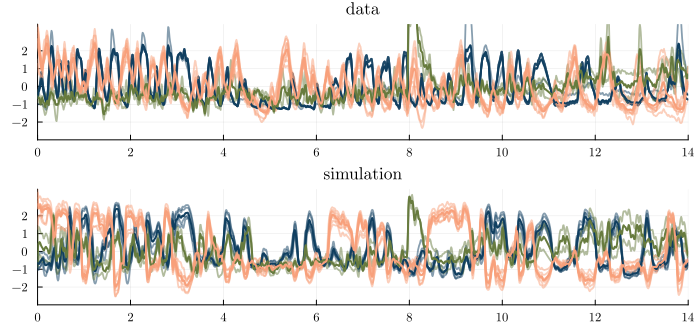

In [11]:
##############################
### Avg F and R clusters #####
##############################

F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_data = vec(mean(Dintrinsic[F_id_range,1:num_t],dims = 1))
avg_avd_data = vec(mean(Dintrinsic[avd_id_range,1:num_t],dims = 1))
avg_R_data = vec(mean(Dintrinsic[R_id_range,1:num_t],dims = 1))

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))

##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################
behav_ts = sign.(mean(Dintrinsic[F_id_range,1:num_t],dims = 1) - mean(Dintrinsic[R_id_range,1:num_t],dims = 1))
behav_ts_sim = sign.(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1) - mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
######################################################
######################################################

########################
#### plot real TS ######
########################
p1 = plot(title = "data",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))
for i in 1:size(Dintrinsic,1)
    plot!(time_vec[1:num_t], Dintrinsic[i,1:num_t], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.5) #label = intrinsic_neurons[i]
end

p1 = plot!(time_vec[1:num_t],avg_F_data, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p1 = plot!(time_vec[1:num_t],avg_avd_data, color = clrs[6], linewidth = 2) # plot avg of avd cluster
p1 = plot!(time_vec[1:num_t],avg_R_data, color = clrs[8], linewidth = 2) # plot avg of reversal cluster

########################
#### plot simulation ######
########################
p2 = plot(title = "simulation",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))
for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.5)
end

p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_avd_sim, color = clrs[6], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2) # plot avg of reversal cluster

pall = plot(p1,p2, layout = (2,1), size = (700,330)) #size = (700,300)

display(pall)
# savefig(pall, path_and_name) # ava plot

#savefig(pall,"figures/new_figs/rev_figs/data_sim_2023-01-05-01.pdf")

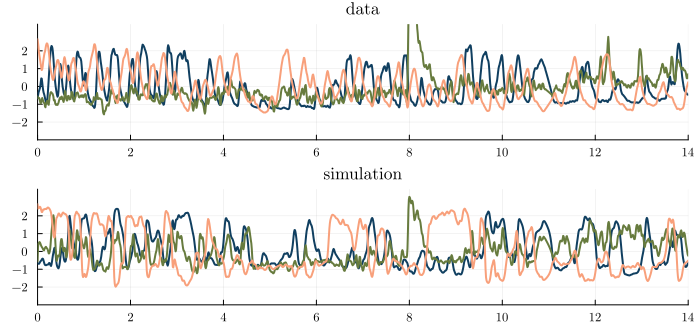

In [12]:
############################
#### plot real TS avg ######
############################
p1 = plot(title = "data",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))

p1 = plot!(time_vec[1:num_t],avg_F_data, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p1 = plot!(time_vec[1:num_t],avg_avd_data, color = clrs[6], linewidth = 2) # plot avg of forward cluster
p1 = plot!(time_vec[1:num_t],avg_R_data, color = clrs[13], linewidth = 2) # plot avg of reversal cluster


##################################
#### plot simulation TS avg ######
##################################
p2 = plot(title = "simulation",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))
p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_avd_sim, color = clrs[6], linewidth = 2) # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[13], linewidth = 2) # plot avg of reversal cluster

pall = plot(p1,p2, layout = (2,1), size = (700,330)) #size = (700,300)

display(pall)

In [13]:
function behav_st(val)
    if val >= 0.5
        val_state = 1
    elseif val <= -0.5
        val_state = -1
    else
        val_state = 0
    end
return val_state
end

function velocity_st(val)
    if val >= 0.01
        val_state = 1
    elseif val <= -0.01
        val_state = -1
    else
        val_state = 0
    end
return val_state
end

velocity_st (generic function with 1 method)

### Correlation of velocity, F, R, z = F-R

## Behavioral_timeseries

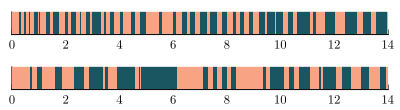

In [14]:
#######################################################
#######################################################
#########        FINAL FIG          ###################
#######################################################
#######################################################

p1 = plot(heatmap(time_vec[1:num_t],[1],-1*behav_ts,c = :batlow10, clim = (-1.7,1.7),
        xticks=(0:2:14), ytick = false, legend=:none), size = (700,100))
p2 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = :batlow10, clim = (-1.7,1.7),
        xticks=(0:2:14), ytick = false, legend=:none), size = (700,100))

pall = plot(p1,p2, layout = (2,1), size = (400,110))  #size = (675,110)
display(pall)


In [15]:
function count_successive_repeats(arr)
    counts = []
    current_count = 1
    
    for i in 1:length(arr)-1
        if arr[i] == arr[i+1]
            current_count += 1
        else
            push!(counts, current_count)
            current_count = 1
        end
    end
    
    push!(counts, current_count)
    return counts
end

count_successive_repeats (generic function with 1 method)

In [16]:
dwell_times_data = count_successive_repeats(behav_ts)
dwell_times_data = dt*dwell_times_data
dwell_times_data_F = dwell_times_data[1:2:end]
dwell_times_data_R = dwell_times_data[2:2:end]

dwell_times_sim = count_successive_repeats(behav_ts_sim)
dwell_times_sim = dt*dwell_times_sim
dwell_times_sim_F = dwell_times_sim[1:2:end]
dwell_times_sim_R = dwell_times_sim[2:2:end];

In [17]:
Dsignals = Dcore_cut[ids_signal,:]
Dintrinsic =Dcore_cut[ids_intrinsic,:]

15×1609 Matrix{Float64}:
 -0.576739  -0.392428  -0.189791  …   1.72248    1.35436    1.20736
 -0.576739  -0.392428  -0.189791      1.72248    1.35436    1.20736
 -0.576739  -0.392428  -0.189791      1.72248    1.35436    1.20736
 -0.576739  -0.392428  -0.189791      1.72248    1.35436    1.20736
 -1.02165   -1.01424   -0.991947      1.87408    1.83656    1.72043
 -0.87742   -0.824841  -0.766734  …   1.21247    1.19165    1.21511
 -0.230292  -0.501196  -0.516125      0.549969   0.744726   0.769628
  2.48661    2.3982     2.21061      -0.222364  -0.225794  -0.315159
  2.9974     2.7912     2.55226      -0.358898  -0.480275  -0.520252
  3.54085    3.36094    3.11839      -0.202588  -0.253213  -0.292893
  3.31546    3.18417    3.00406   …  -0.16166   -0.207732  -0.269298
  3.28381    3.04995    2.70659      -0.51341   -0.5575    -0.619486
  2.81584    2.45531    2.06278      -0.816037  -0.904671  -0.898984
  1.51152    1.32511    1.18893      -0.780851  -0.858883  -1.01216
  1.26663    1.0

## Time lag correlation with R

## Do simulation with certain neurons cut out

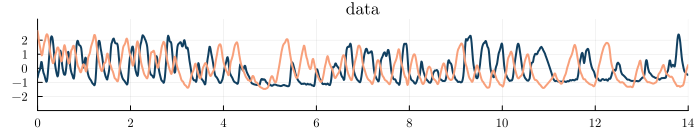

In [18]:
########################
#### plot real TS ######
########################
p1 = plot(title = "data",ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))
p1 = plot!(time_vec[1:num_t],avg_F_data, color = clrs[1], linewidth = 2) # plot avg of forward cluster
p1 = plot!(time_vec[1:num_t],avg_R_data, color = clrs[8], linewidth = 2) # plot avg of reversal cluster


p1 = plot!(size = (700,130)) #size = (700,300)

# Knock out forward drivers, reversal drivers, forward suppressors, reversal suppressors

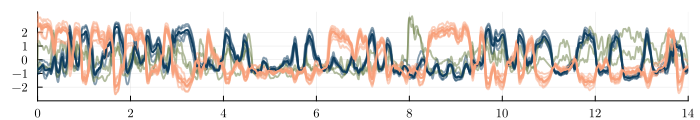

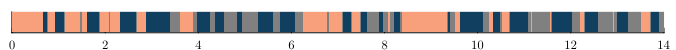

0.3433261955745896

In [19]:
####################
####################
### Get signals ####
####################
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]


#################
##############
Dsignals = 1*Dcore_cut[ids_signal,:]
################
################

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)


########################
#### plot simulation ######
########################
p2 = plot(ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))

for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.5)
end

p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # , label = L"F(t)" # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2)  #label = L"R(t)" # plot avg of reversal cluster

p2 = plot!(size = (700,120)) # legend =:outerleft, #size = (700,300)
display(p2)

######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#pall = plot(p2,p3, layout = (2,1), size = (700,220))
#display(pall)

#savefig(p2,"figures/sig_promoters/2023-01-23-15/baseline_ts_2023-01-23-15.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/baseline_behav_2023-01-23-15.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_base = num_F/tot
per_R_base = num_R/tot

In [20]:
# A  # entire matrix of synaptic weights

A_sigtoF = A[ids_intrinsic[F_id_range],ids_signal]  # synaptic connections from sig neurons just to Forward cluster
A_sigtoR = A[ids_intrinsic[R_id_range],ids_signal]  # synaptic connections from sig neurons just to Reversal cluster

#Dsignals = 1*Dcore_cut[ids_signal,:]

Relu_Dsigs = Relu.(Dsignals) 

AF_Dsigs = zeros(size(Relu_Dsigs))
AR_Dsigs = zeros(size(Relu_Dsigs))

for i in collect(1:size(AF_Dsigs, 2))
    AF_Dsigs[:,i] = vec(sum(A_sigtoF.*Relu_Dsigs[:,i]', dims = 1))   # Dsigs relued and weighted by A and summed over F
    AR_Dsigs[:,i] = vec(sum(A_sigtoR.*Relu_Dsigs[:,i]', dims = 1))   # Dsigs relued and weighted by A and summed over R
end

AF_Dsigs = AF_Dsigs[:,1:num_steps+1]
AR_Dsigs = AR_Dsigs[:,1:num_steps+1]

###############################################
###  behav_ts_sim , find where it switches  ###
###############################################
t_ids_switch_toF = []
t_ids_switch_toR = []

for i in collect(2:length(behav_ts_sim))
    if (behav_ts_sim[i] ==1) & (behav_ts_sim[i-1] <1)
        t_ids_switch_toF = append!(t_ids_switch_toF, i)
    end
end

for i in collect(2:length(behav_ts_sim))
    if (behav_ts_sim[i] ==-1) & (behav_ts_sim[i-1] >-1)
        t_ids_switch_toR = append!(t_ids_switch_toR, i)
    end
end



In [21]:
AF_Dsigs_snips = zeros(size(AF_Dsigs, 1), 1)
AR_Dsigs_snips = zeros(size(AR_Dsigs, 1), 1)

AF_Dsigs_snips_beforeR = zeros(size(AF_Dsigs, 1), 1)
AR_Dsigs_snips_beforeF = zeros(size(AR_Dsigs, 1), 1)

####  get weighted activity of each neuron before switch to forward  ####
for t_idx in t_ids_switch_toF
    #println(t_idx)
    AF_Dsigs_snips = hcat(AF_Dsigs_snips, AF_Dsigs[:,t_idx-10:t_idx])  #take activity in the 10 step interval before a switch to F

    AR_Dsigs_snips_beforeF = hcat(AR_Dsigs_snips_beforeF, AR_Dsigs[:,t_idx-10:t_idx])  #take activity in the 10 step interval before a switch to F
end
sig_level_beforeF = vec(sum(AF_Dsigs_snips, dims = 2))
sig_level_R_beforeF = vec(sum(AR_Dsigs_snips_beforeF, dims = 2))


####  get weighted activity of each neuron before switch to reversal  ####
for t_idx in t_ids_switch_toR[2:end]
    #println(t_idx)
    AR_Dsigs_snips = hcat(AR_Dsigs_snips, AR_Dsigs[:,t_idx-10:t_idx])  #take activity in the 10 step interval before a switch to R

    AF_Dsigs_snips_beforeR = hcat(AF_Dsigs_snips_beforeR, AF_Dsigs[:,t_idx-10:t_idx])  #take activity in the 10 step interval before a switch to R
end


sig_level_beforeR = vec(sum(AR_Dsigs_snips, dims = 2))
sig_level_F_beforeR = vec(sum(AF_Dsigs_snips_beforeR, dims = 2))

#########   F before F and R before R   #############
F_id_sort = sortperm(sig_level_beforeF, rev = true)
sig_level_beforeF_sorted = sig_level_beforeF[F_id_sort]
Fsig_names_sorted = core_neurons[ids_signal][F_id_sort]


R_id_sort = sortperm(sig_level_beforeR, rev = true)
sig_level_beforeR_sorted = sig_level_beforeR[R_id_sort]
Rsig_names_sorted = core_neurons[ids_signal][R_id_sort]


#########   Now for R before F and F before R   #############
F_id_sort_beforeR = sortperm(sig_level_F_beforeR, rev = true)
R_id_sort_beforeF = sortperm(sig_level_R_beforeF, rev = true)

sig_level_F_beforeR_sorted = sig_level_F_beforeR[F_id_sort_beforeR]
Fsig_beforeR_names_sorted = core_neurons[ids_signal][F_id_sort_beforeR]

sig_level_R_beforeF_sorted = sig_level_R_beforeF[R_id_sort_beforeF]
Rsig_beforeF_names_sorted = core_neurons[ids_signal][R_id_sort_beforeF]


57-element Vector{String7}:
 "AIZR"
 "URYDL"
 "URYDR"
 "URYVL"
 "ADAL"
 "ASGR"
 "ASGL"
 "AWCL"
 "RICL"
 "AUAL"
 ⋮
 "CEPDR"
 "CEPVL"
 "URXL"
 "ADEL"
 "AVJR"
 "IL1R"
 "URXR"
 "CEPDL"
 "FLPL"

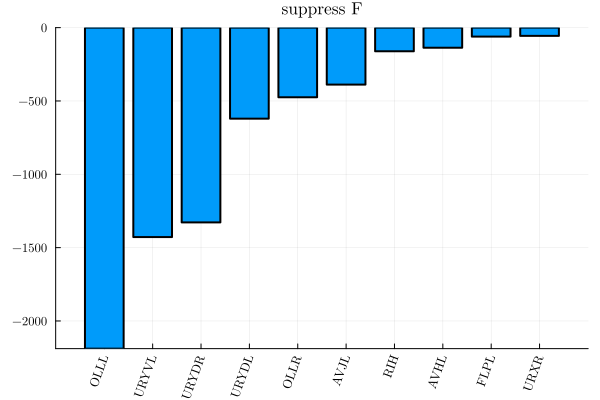

In [22]:
# Bar plot with x-ticks labeled by names

#######################
##  cut out middle  ###
sig_level_beforeF_sorted_pos =sig_level_beforeF_sorted[1:10]
sig_level_beforeF_sorted_neg =sig_level_beforeF_sorted[end-9:end]

sig_level_beforeR_sorted_pos =sig_level_beforeR_sorted[1:10]
sig_level_beforeR_sorted_neg =sig_level_beforeR_sorted[end-9:end]
#######################
#######################

#######################
### cut out middle  ###
sig_level_F_beforeR_sorted_pos =sig_level_F_beforeR_sorted[1:10]
sig_level_F_beforeR_sorted_neg =sig_level_F_beforeR_sorted[end-9:end]

sig_level_R_beforeF_sorted_pos =sig_level_R_beforeF_sorted[1:10]
sig_level_R_beforeF_sorted_neg =sig_level_R_beforeF_sorted[end-9:end]
#######################
#######################

#bar(1:58, sig_level_beforeF_sorted, xticks=(1:58, Fsig_names_sorted), xrotation=70)

p1 = bar(1:10, sig_level_beforeF_sorted_pos, xticks=(1:10, Fsig_names_sorted[1:10]), xrotation=70, title = "promote F")
p4 = bar(1:10, reverse(sig_level_R_beforeF_sorted_neg), xticks=(1:10, reverse(Rsig_beforeF_names_sorted[end-9:end])), xrotation=70, title = "suppress R")


p3 =  bar(1:10, sig_level_beforeR_sorted_pos, xticks=(1:10, Rsig_names_sorted[1:10]), xrotation=70, title = "promote R")
p2 = bar(1:10, reverse(sig_level_F_beforeR_sorted_neg), xticks=(1:10, reverse(Fsig_beforeR_names_sorted[end-9:end])), xrotation=70, title = "suppress F")



#pall = plot!(p1,p3, layout = (1,2), size = (500,200), bottom_margin = 5mm)
# pall = plot!(p1,p4, layout = (1,2), size = (500,200), bottom_margin = 5mm)
# display(pall)

#savefig(pall,"figures/sig_promoters/top_pos_sigs.pdf")
#savefig(pall,"figures/sig_promoters/top_pos_sigs2.pdf")

######   Promote F   ########
#pall = plot!(p1, size = (250,200), bottom_margin = 5mm)
#savefig(pall,"figures/sig_promoters/promote_F.pdf")
#savefig(pall,"figures/sig_promoters/2023-01-23-15/promote_F.pdf")

######   Suppress F   ########
#pall = plot!(p2, size = (250,200), bottom_margin = 5mm)
#savefig(pall,"figures/sig_promoters/suppress_F.pdf")
#savefig(pall,"figures/sig_promoters/2023-01-23-15/suppress_F.pdf")


######   Promote R   ########
#pall = plot!(p3, size = (250,200), bottom_margin = 5mm)
#savefig(pall,"figures/sig_promoters/promote_R.pdf")
#savefig(pall,"figures/sig_promoters/2023-01-23-15/promote_R.pdf")

######   Suppress R   ########
#pall = plot!(p4, size = (250,200), bottom_margin = 5mm)
#savefig(pall,"figures/sig_promoters/suppress_R.pdf")
#savefig(pall,"figures/sig_promoters/2023-01-23-15/suppress_R.pdf")

# Figure 5

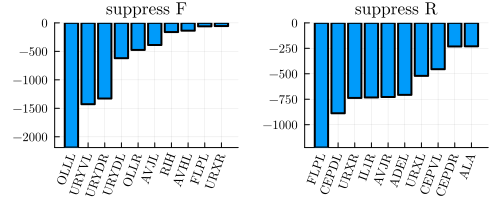

In [23]:


pall = plot!(p2,p4, layout = (1,2), size = (500,200), bottom_margin = 5mm)
display(pall)

#savefig(pall,"figures/sig_promoters/top_neg_sigs.pdf")

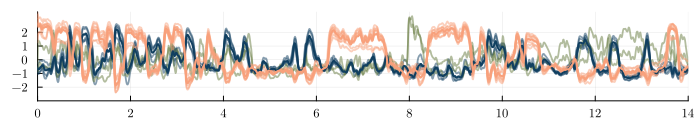

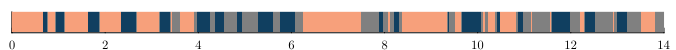

String7["RMED"]

In [24]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

######## NEW  #########
###  cut out suspiciously "important" neurons ###
######################

#######################################################
### CUT IMPORTANT SIGNAL NEURONS  #####
#######################################################


###########################
###  cut F promoters  #####
###########################
ids_to_cut = [core_neurons_dict[Fsig_names_sorted[1]]]

#ids_to_cut = [core_neurons_dict[Fsig_names_sorted[1]], core_neurons_dict[Fsig_names_sorted[2]]]

#ids_to_cut = [core_neurons_dict[Fsig_names_sorted[1]], core_neurons_dict[Fsig_names_sorted[2]], core_neurons_dict[Fsig_names_sorted[3]]]

# ids_to_cut = [core_neurons_dict[Fsig_names_sorted[1]], core_neurons_dict[Fsig_names_sorted[2]], core_neurons_dict[Fsig_names_sorted[3]],
#                 core_neurons_dict[Fsig_names_sorted[4]], core_neurons_dict[Fsig_names_sorted[5]]]

###########################
###  cut R promoters  #####
###########################
#ids_to_cut = [core_neurons_dict[Rsig_names_sorted[1]]]

#ids_to_cut = [core_neurons_dict[Rsig_names_sorted[1]], core_neurons_dict[Rsig_names_sorted[2]]]
 
#ids_to_cut = [core_neurons_dict[Rsig_names_sorted[1]], core_neurons_dict[Rsig_names_sorted[2]], core_neurons_dict[Rsig_names_sorted[3]]]

# ids_to_cut = [core_neurons_dict[Rsig_names_sorted[1]], core_neurons_dict[Rsig_names_sorted[2]], core_neurons_dict[Rsig_names_sorted[3]],
#                 core_neurons_dict[Rsig_names_sorted[4]], core_neurons_dict[Rsig_names_sorted[5]]]



###########################
###  cut F suppressors  #####
###########################
#ids_to_cut = [core_neurons_dict[Fsig_beforeR_names_sorted[end]]]

#ids_to_cut = [core_neurons_dict[Fsig_beforeR_names_sorted[end]], core_neurons_dict[Fsig_beforeR_names_sorted[end-1]]]

# ids_to_cut = [core_neurons_dict[Fsig_beforeR_names_sorted[end]], core_neurons_dict[Fsig_beforeR_names_sorted[end-1]],
#                 core_neurons_dict[Fsig_beforeR_names_sorted[end-2]]]

# ids_to_cut = [core_neurons_dict[Fsig_beforeR_names_sorted[end]], core_neurons_dict[Fsig_beforeR_names_sorted[end-1]],
#                 core_neurons_dict[Fsig_beforeR_names_sorted[end-2]], core_neurons_dict[Fsig_beforeR_names_sorted[end-3]],
#                 core_neurons_dict[Fsig_beforeR_names_sorted[end-4]]]

##############################
###  cut R suppressors  ######
##############################
#ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]]]

#ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]]]

# ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]],
#                 core_neurons_dict[Rsig_beforeF_names_sorted[end-2]]]

# ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]],
#                 core_neurons_dict[Rsig_beforeF_names_sorted[end-2]], core_neurons_dict[Rsig_beforeF_names_sorted[end-3]]]

# ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]],
#                  core_neurons_dict[Rsig_beforeF_names_sorted[end-2]], core_neurons_dict[Rsig_beforeF_names_sorted[end-3]],
#                  core_neurons_dict[Rsig_beforeF_names_sorted[end-4]]]

# ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]],
#                  core_neurons_dict[Rsig_beforeF_names_sorted[end-2]], core_neurons_dict[Rsig_beforeF_names_sorted[end-3]],
#                  core_neurons_dict[Rsig_beforeF_names_sorted[end-4]], core_neurons_dict[Rsig_beforeF_names_sorted[end-5]]]


print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 
###############################
###############################


#################
##############
Dsignals = 1*Dcore_cut[ids_signal,:]


################
################
Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

F_data_ts = mean(Dintrinsic[1:5,1:num_steps+1],dims = 1)
R_data_ts = mean(Dintrinsic[8:13,1:num_steps+1],dims = 1)


########################
#### plot simulation ######
########################
p2 = plot(ytick = -2:1:2, xlim = (0,14), ylim = (-3,3.5))

for i in collect(1:Nintrinsic)
    plot!(sol_EJ_Syn.t,sol_EJ_Syn[i,:], label = false, color = clrs[i], linewidth = 1.8, alpha = 0.5)
end

p2 = plot!(time_vec[1:num_t],avg_F_sim, color = clrs[1], linewidth = 2) # , label = L"F(t)" # plot avg of forward cluster
p2 = plot!(time_vec[1:num_t],avg_R_sim, color = clrs[8], linewidth = 2)  #label = L"R(t)" # plot avg of reversal cluster

p2 = plot!(size = (700,120)) # legend =:outerleft, #size = (700,300)
display(p2)


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)


#savefig(p2,"figures/sig_promoters/FR_ts.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav.pdf")


#savefig(p3,"figures/sig_promoters/FR_ts_behav_F_cut1.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_F_cut2.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_F_cut3.pdf")


#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut1.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut2.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut3.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut5.pdf")


# savefig(p2,"figures/sig_promoters/FR_ts_2.pdf")
# savefig(p3,"figures/sig_promoters/FR_ts_behav_2.pdf")


#savefig(p3,"figures/sig_promoters/FR_ts_behav_F_cut1_2.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_F_cut2_2.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_F_cut3_2.pdf")

#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut1_2.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut2_2.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut3_2.pdf")
#savefig(p3,"figures/sig_promoters/FR_ts_behav_R_cut5_2.pdf")


###########################################################
##### promotors and suppressors dataset 2023-01-05-01 #####
###########################################################

#savefig(p3,"figures/sig_promoters/promoteF_1.pdf")
#savefig(p3,"figures/sig_promoters/promoteF_2.pdf")
#savefig(p3,"figures/sig_promoters/promoteF_3.pdf")
#savefig(p3,"figures/sig_promoters/promoteF_5.pdf")

#savefig(p3,"figures/sig_promoters/promoteR_1.pdf")
#savefig(p3,"figures/sig_promoters/promoteR_2.pdf")
#savefig(p3,"figures/sig_promoters/promoteR_3.pdf")
#savefig(p3,"figures/sig_promoters/promoteR_5.pdf")


#savefig(p3,"figures/sig_promoters/suppressF_1.pdf")
#savefig(p3,"figures/sig_promoters/suppressF_2.pdf")
#savefig(p3,"figures/sig_promoters/suppressF_3.pdf")
#savefig(p3,"figures/sig_promoters/suppressF_5.pdf")

#savefig(p3,"figures/sig_promoters/suppressR_1.pdf")
#savefig(p3,"figures/sig_promoters/suppressR_2.pdf")
#savefig(p3,"figures/sig_promoters/suppressR_3.pdf")
#savefig(p3,"figures/sig_promoters/suppressR_4.pdf")
#savefig(p3,"figures/sig_promoters/suppressR_5.pdf")
#savefig(p3,"figures/sig_promoters/suppressR_6.pdf")


##############################################################
##### promotors and suppressors - dataset 2023-01-23-15  #####
##############################################################


#savefig(p3,"figures/sig_promoters/2023-01-23-15/promoteF_1.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/promoteF_3.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/promoteF_5.pdf")

#savefig(p3,"figures/sig_promoters/2023-01-23-15/promoteR_1.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/promoteR_3.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/promoteR_5.pdf")


#savefig(p3,"figures/sig_promoters/2023-01-23-15/suppressF_1.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/suppressF_3.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/suppressF_5.pdf")

#savefig(p3,"figures/sig_promoters/2023-01-23-15/suppressR_1.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/suppressR_3.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/suppressR_5.pdf")
#savefig(p3,"figures/sig_promoters/2023-01-23-15/suppressR_6.pdf")


In [25]:
###############
###############
###############
###############
###############
###############

# dataset 2023-01-05-01
## Cut promote F 1

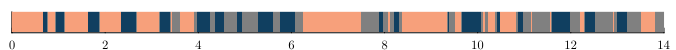

String7["RMED"]

0.42683797287651676

In [26]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut F promoters  #####
###########################
ids_to_cut = [core_neurons_dict[Fsig_names_sorted[1]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/promoteF_1.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_promote_F1 = num_F/tot
per_R_promote_F1 = num_R/tot

# dataset 2023-01-05-01
## Cut promote F 2

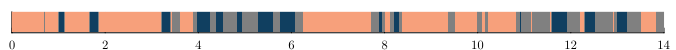

String7["RMED", "AUAL"]

0.5217701641684511

In [27]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut F promoters  #####
###########################
ids_to_cut = [core_neurons_dict[Fsig_names_sorted[1]], core_neurons_dict[Fsig_names_sorted[2]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)


#savefig(p3,"figures/sig_promoters/2023-01-05-01/promoteF_2.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_promote_F2 = num_F/tot
per_R_promote_F2 = num_R/tot

# promotors and suppressors dataset 2023-01-05-01
## Cut promote F 3

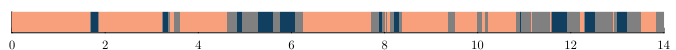

String7["RMED", "AUAL", "CEPDR"]

0.5952890792291221

In [28]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut F promoters  #####
###########################
ids_to_cut = [core_neurons_dict[Fsig_names_sorted[1]], core_neurons_dict[Fsig_names_sorted[2]], core_neurons_dict[Fsig_names_sorted[3]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################

######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)


#savefig(p3,"figures/sig_promoters/2023-01-05-01/promoteF_3.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_promote_F3 = num_F/tot
per_R_promote_F3 = num_R/tot

## ratio fig, promote F

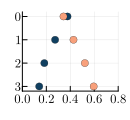

[0.377, 0.273, 0.183, 0.141]
[0.343, 0.427, 0.522, 0.595]


In [29]:

num_set_zero = [0,1,2,3]
per_F = [per_F_base, per_F_promote_F1, per_F_promote_F2, per_F_promote_F3]
per_R = [per_R_base, per_R_promote_F1, per_R_promote_F2, per_R_promote_F3]


#######  Plot signal neurons that will be cut  ##########
p1 = plot(xtick = 0:0.2:1, xlim = (0,0.8), ylim = (-0.2,3.2), yflip = true, size = (130,120))

p1 = scatter!(per_F, num_set_zero, color = clrs[1], linewidth = 3)
p1 = scatter!(per_R, num_set_zero, color = clrs[8], linewidth = 3)

display(p1)

#savefig(p1,"figures/sig_promoters/2023-01-05-01/promoteF_percent_time.pdf")


println(round.(per_F, digits= 3))
println(round.(per_R, digits= 3))

# promotors and suppressors dataset 2023-01-05-01
## Cut suppress R 2

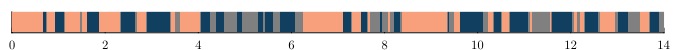

String7["FLPL", "CEPDL"]

0.4011420413990007

In [30]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

##############################
###  cut R suppressors  ######
##############################
ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/suppressR_2.pdf")



#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_suppress_R2 = num_F/tot
per_R_suppress_R2 = num_R/tot

# promotors and suppressors dataset 2023-01-05-01
## Cut suppress R 4

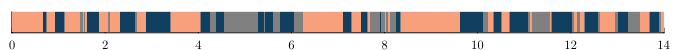

String7["FLPL", "CEPDL", "URXR", "IL1R"]

0.4189864382583869

In [31]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

##############################
###  cut R suppressors  ######
##############################
ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]],
                core_neurons_dict[Rsig_beforeF_names_sorted[end-2]], core_neurons_dict[Rsig_beforeF_names_sorted[end-3]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/suppressR_2.pdf")



#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_suppress_R4 = num_F/tot
per_R_suppress_R4 = num_R/tot

# promotors and suppressors dataset 2023-01-05-01
## Cut suppress R 6

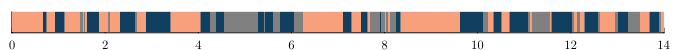

String7["FLPL", "CEPDL", "URXR", "IL1R"]

0.4189864382583869

In [32]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

##############################
###  cut R suppressors  ######
##############################
ids_to_cut = [core_neurons_dict[Rsig_beforeF_names_sorted[end]], core_neurons_dict[Rsig_beforeF_names_sorted[end-1]],
                core_neurons_dict[Rsig_beforeF_names_sorted[end-2]], core_neurons_dict[Rsig_beforeF_names_sorted[end-3]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/suppressR_6.pdf")



#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_suppress_R6 = num_F/tot
per_R_suppress_R6 = num_R/tot

# Ratio fig, Suppress R

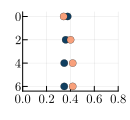

[0.377, 0.36, 0.348, 0.348]
[0.343, 0.401, 0.419, 0.419]


In [33]:
num_set_zero = [0,2,4,6]
per_F = [per_F_base, per_F_suppress_R2, per_F_suppress_R4, per_F_suppress_R6]
per_R = [per_R_base, per_R_suppress_R2, per_R_suppress_R4, per_R_suppress_R6]


#######  Plot signal neurons that will be cut  ##########
p1 = plot(xtick = 0:0.2:1, xlim = (0,0.8), ylim = (-0.4,6.4), ytick = 0:2:6, yflip = true, size = (130,120))

p1 = scatter!(per_F, num_set_zero, color = clrs[1], linewidth = 3)
p1 = scatter!(per_R, num_set_zero, color = clrs[8], linewidth = 3)

display(p1)

#savefig(p1,"figures/sig_promoters/2023-01-05-01/suppressR_percent_time.pdf")

println(round.(per_F, digits= 3))
println(round.(per_R, digits= 3))

#  dataset 2023-01-05-01 __ Cut promote R 1

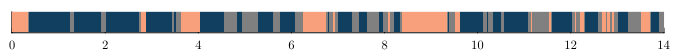

String7["URYVL"]

0.22483940042826553

In [34]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut R promoters  #####
###########################
ids_to_cut = [core_neurons_dict[Rsig_names_sorted[1]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/promoteR_1.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_promote_R1 = num_F/tot
per_R_promote_R1 = num_R/tot

# dataset 2023-01-05-01 __ Cut promote R 2

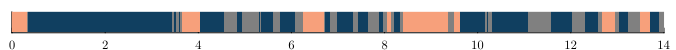

String7["URYVL", "URYDR"]

0.2012847965738758

In [35]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut R promoters  #####
###########################
ids_to_cut = [core_neurons_dict[Rsig_names_sorted[1]], core_neurons_dict[Rsig_names_sorted[2]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/promoteR_2.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_promote_R2 = num_F/tot
per_R_promote_R2 = num_R/tot

# dataset 2023-01-05-01 __ Cut promote R 3

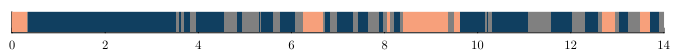

String7["URYVL", "URYDR", "AIZR"]

0.17273376159885795

In [36]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut R promoters  #####
###########################
ids_to_cut = [core_neurons_dict[Rsig_names_sorted[1]], core_neurons_dict[Rsig_names_sorted[2]], core_neurons_dict[Rsig_names_sorted[3]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/promoteR_3.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_promote_R3 = num_F/tot
per_R_promote_R3 = num_R/tot

## Ratio fig, promote R

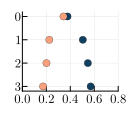

[0.377, 0.505, 0.547, 0.57]
[0.343, 0.225, 0.201, 0.173]


In [37]:

num_set_zero = [0,1,2,3]
per_F = [per_F_base, per_F_promote_R1, per_F_promote_R2, per_F_promote_R3]
per_R = [per_R_base, per_R_promote_R1, per_R_promote_R2, per_R_promote_R3]


#######  Plot signal neurons that will be cut  ##########
p1 = plot(xtick = 0:0.2:1, xlim = (0,0.8), ylim = (-0.2,3.2), yflip = true, size = (130,120))

p1 = scatter!(per_F, num_set_zero, color = clrs[1], linewidth = 3)
p1 = scatter!(per_R, num_set_zero, color = clrs[8], linewidth = 3)

display(p1)

#savefig(p1,"figures/sig_promoters/2023-01-05-01/promoteR_percent_time.pdf")

println(round.(per_F, digits= 3))
println(round.(per_R, digits= 3))

#  dataset 2023-01-05-01 __ Cut suppress F 1

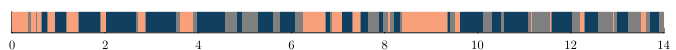

String7["OLLL"]

0.2648108493932905

In [38]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut F suppressors  #####
###########################
ids_to_cut = [core_neurons_dict[Fsig_beforeR_names_sorted[end]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/suppressF_1.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_suppress_F1 = num_F/tot
per_R_suppress_F1 = num_R/tot

# dataset 2023-01-05-01 __ Cut suppress F 2

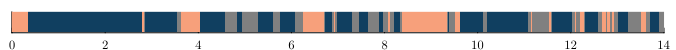

String7["OLLL", "URYVL"]

0.20985010706638116

In [39]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut F suppressors  #####
###########################
ids_to_cut = [core_neurons_dict[Fsig_beforeR_names_sorted[end]], core_neurons_dict[Fsig_beforeR_names_sorted[end-1]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/suppressF_2.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_suppress_F2 = num_F/tot
per_R_suppress_F2 = num_R/tot

# dataset 2023-01-05-01 __ Cut suppress F 3

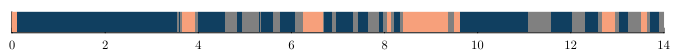

String7["OLLL", "URYVL", "URYDR"]

0.17130620985010706

In [40]:
##########
#########
### Get signals ###
tstart = 5  #tstart = 5, 100, 600, 900
Dcore = D[ids_core,:]
Dcore_cut = Dcore[:,tstart:end]

###########################
###  cut F suppressors  #####
###########################
ids_to_cut = [core_neurons_dict[Fsig_beforeR_names_sorted[end]], core_neurons_dict[Fsig_beforeR_names_sorted[end-1]], core_neurons_dict[Fsig_beforeR_names_sorted[end-2]]]

print(core_neurons[ids_to_cut])

#######  Plot signal neurons that will be cut  ##########
p1 = plot(ytick = -2:2:2, xtick = 0:2:14, xlim = (0,14), ylim = (-3,4))
for i in collect(1:length(ids_to_cut))

    p1 = plot!(time_vec[1:num_t],Dcore_cut[ids_to_cut[i],1:num_t], label = core_neurons[ids_to_cut[i]])
end
p1 = plot!(legend=:outerleft,size = (800,100)) #size = (700,300)
####################################################

###############################
###  cut signals  #############
###############################
Dcore_cut[ids_to_cut,:] = 0*Dcore_cut[ids_to_cut,:]  # set random subset of correlates to zero 

Dsignals = 1*Dcore_cut[ids_signal,:]

Dintrinsic =Dcore_cut[ids_intrinsic,:]
u0 = Dintrinsic[:,1] # initial condition

num_steps = 1400
t_short = dt*collect(0:num_steps)
num_t = length(t_short)

####### get interpolations for the signal timeseries ####
Dsigs_interp = []
for i in 1:Nsignals
    itp = LinearInterpolation(Dsignals[i,1:num_steps+1], t_short)
    push!(Dsigs_interp, itp)
end

tspan = (0.0,t_short[end])  # timespan for the ode

#######################################
## both synaptic and EJ connections ###
#######################################

p = (γ, β, τ)
prob = ODEProblem(lorenz!,u0,tspan, p)
sol_EJ_Syn = solve(prob,Tsit5(), saveat=t_short);


###############
###  PLOT   ###
###############

##############################
### Avg F and R clusters #####
##############################
F_id_range = 1:5    # ids for forward intrinsic neurons
avd_id_range = 6:7  # ids for avd intrinsic neurons
R_id_range = 8:15   # ids for reversal intrinsic neurons

avg_F_sim = vec(mean(sol_EJ_Syn[F_id_range,1:num_t],dims = 1))
avg_avd_sim = vec(mean(sol_EJ_Syn[avd_id_range,1:num_t],dims = 1))
avg_R_sim = vec(mean(sol_EJ_Syn[R_id_range,1:num_t],dims = 1))
##############################
##############################


######################################################
### Behavioral timeseries of data and simulation #####
######################################################

thresh = 0.5

z_sim_ts = avg_F_sim - avg_R_sim
z_sim_ts[z_sim_ts .> thresh] .= 1
z_sim_ts[z_sim_ts .< -thresh] .= -1
z_sim_ts[(z_sim_ts .> -thresh).*(z_sim_ts .< thresh)] .=0
behav_ts_sim = sign.(z_sim_ts)

######################################################
######################################################

######### Make ambiguous regions grey ##########
c1 = palette(:batlow10)|> collect
c1 = c1[2:8]
c1[3] = :grey
c1[4] = :grey
c1[5] = :grey

behav_ts_sim = reshape(behav_ts_sim,1,:)

p3 = plot(heatmap(time_vec[1:num_t], [1], -1*behav_ts_sim, c = c1, clim = (-1,1), 
        xticks=(0:2:14), ytick = false, legend=:none), size = (676,50))

display(p3)

#savefig(p3,"figures/sig_promoters/2023-01-05-01/suppressF_3.pdf")


#####################################################################
#### compute percentage of time in Forward and Reversal states  #####
#####################################################################

num_F = sum(behav_ts_sim .== 1)
num_R = sum(behav_ts_sim .== -1)
num_P = sum(behav_ts_sim .== 0)
tot = num_F + num_R + num_P

per_F_suppress_F3 = num_F/tot
per_R_suppress_F3 = num_R/tot

## Ratio fig, suppress F

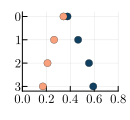

[0.377, 0.465, 0.556, 0.592]
[0.343, 0.265, 0.21, 0.171]


In [41]:

num_set_zero = [0,1,2,3]
per_F = [per_F_base, per_F_suppress_F1, per_F_suppress_F2, per_F_suppress_F3]
per_R = [per_R_base, per_R_suppress_F1, per_R_suppress_F2, per_R_suppress_F3]


#######  Plot signal neurons that will be cut  ##########
p1 = plot(xtick = 0:0.2:1, xlim = (0,0.8), ylim = (-0.2,3.2), yflip = true, size = (130,120))

p1 = scatter!(per_F, num_set_zero, color = clrs[1], linewidth = 3)
p1 = scatter!(per_R, num_set_zero, color = clrs[8], linewidth = 3)

display(p1)

#savefig(p1,"figures/sig_promoters/2023-01-05-01/suppressF_percent_time.pdf")

println(round.(per_F, digits= 3))
println(round.(per_R, digits= 3))